In [6]:
## imports ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import MFTime
import MFParse
import os
import scipy.signal
####

## global ##
dataPath='/Users/ziegler/repos/mayfly/output/timeSeries1252021.pkl'
simPath='/Users/ziegler/p8/egg_files/eggsTemplates1252021/'
templatePitchAngles=np.linspace(85,90,51)
templatePos=np.linspace(0,5e-2,21)
radius=0.00
#nPeaks=5
nTest=256
noiseVar=2.3e-14
colors=['r','b','g','c','m','k']
frequencyConversion=200e6/8192
array_rad=0.1
Vrange=(80-280*array_rad+300*array_rad**2)*1e-9
nSlice=2
sliceSize=8192
samplePeriod=5e-9
####

## definitions ##

def getEggFilePaths(dirPath,listOfPaths):
    try:
        os.path.isdir(dirPath)
    except:
        return False

    for fPath in os.listdir(dirPath):
        if fPath.split('.')[-1]=='egg':
            listOfPaths.append(os.path.join(dirPath,fPath))

    return True

def getEggFileParams(eggPath,params):
    try:
        os.path.isfile(eggPath)
    except:
        return False

    try:
        pitchAngle=float(eggPath.split('/')[-1].split('Angle')[-1].split('_')[0])
        radius=float(eggPath.split('/')[-1].split('Pos')[-1].split('.egg')[0])
    except:
        return False

    params.append(pitchAngle)
    params.append(radius)

    return True

def getSimpleTemplate(frequencies,amplitudes,phases,nSample,dT):

    simpleTemplate=np.zeros(nSample,dtype=np.complex128)
    time=np.arange(0,nSample,1)*dT
    for i in range(len(frequencies)):
        simpleTemplate+=amplitudes[i]*np.exp(+1j*2*np.pi*(frequencies[i]*time+phases[i]))

    return simpleTemplate

def addNoise(input,var):

    noise=np.random.multivariate_normal([0,0],np.eye(2)*var/2,len(input))
    noise=noise[:,0]+1j*noise[:,1]

    return input+noise

def getSimpleFrequencyEstimate(frequencySeries,threshold=0.25):

    maxValue=np.max(abs(frequencySeries))
    maxInd=np.argmax(abs(frequencySeries))
    #print(maxInd)

    rawPeakInds=np.where(abs(frequencySeries)>threshold*maxValue)[0]
    
    bigPeakInd=np.flip(np.argsort(abs(frequencySeries)))[0:10]
    bigPeakAmp=abs(frequencySeries[bigPeakInd])
    
    groupedPeakIndInd=np.argsort(bigPeakInd)
    
    groupedPeakInd=bigPeakInd[groupedPeakIndInd]
    groupedPeakAmp=bigPeakAmp[groupedPeakIndInd]

    return groupedPeakInd,groupedPeakAmp

####


# compare simple template with zero phases but correct amplitudes

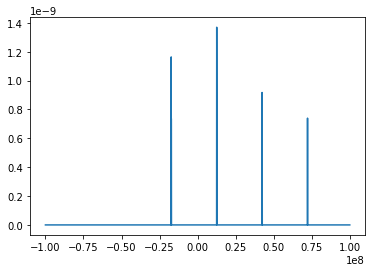

press enter


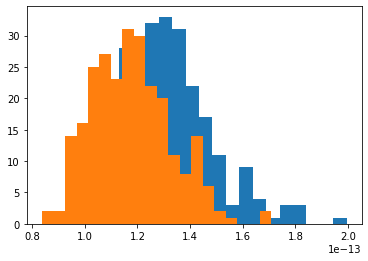

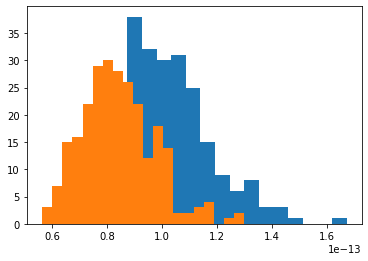

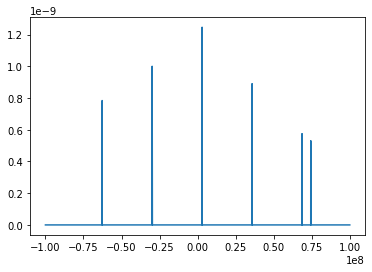

press enter


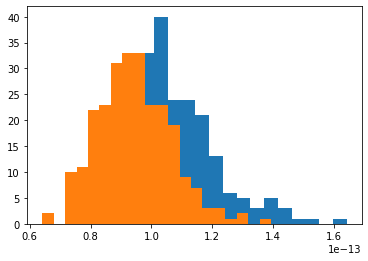

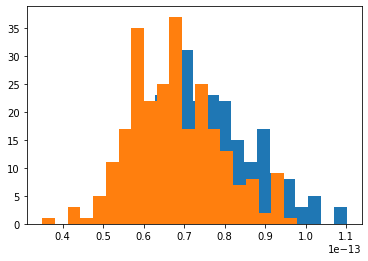

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle86.10_Pos0.043.egg


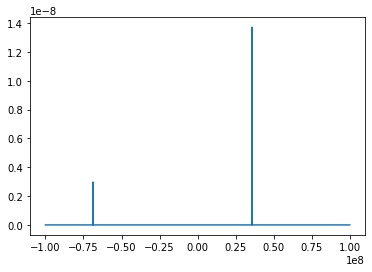

press enter


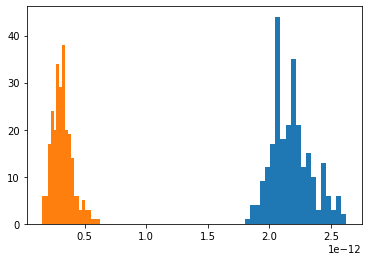

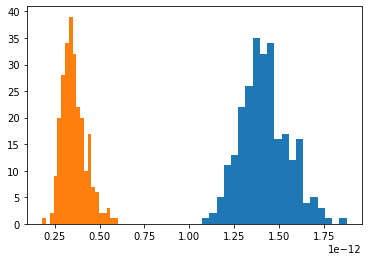

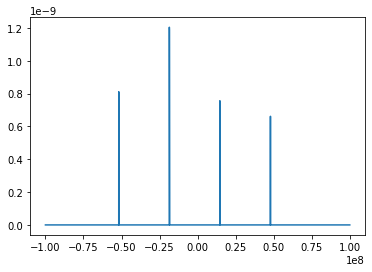

press enter


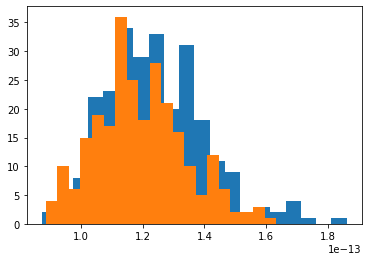

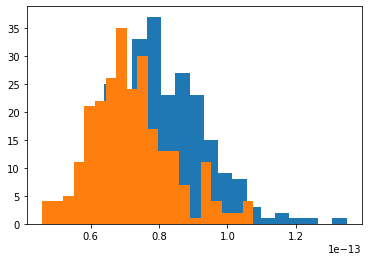

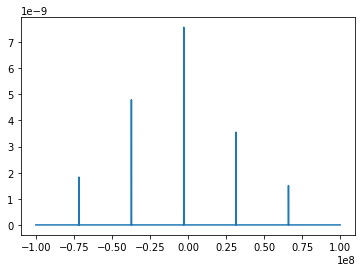

press enter


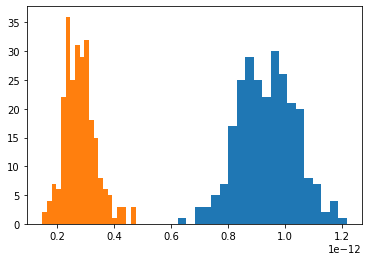

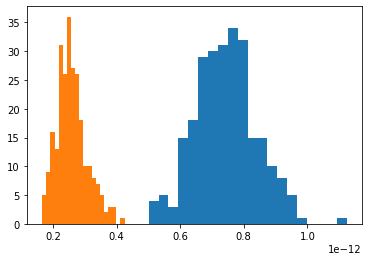

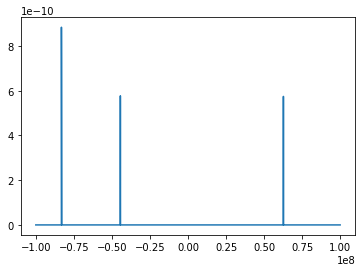

press enter


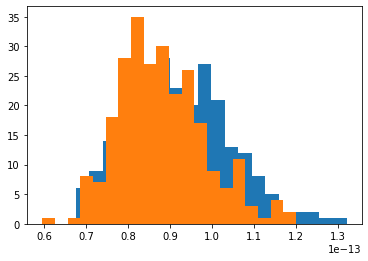

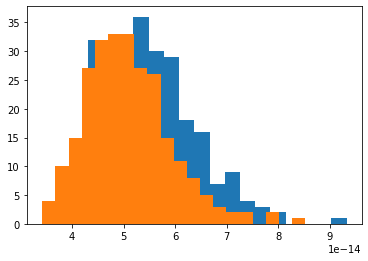

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle89.30_Pos0.037.egg


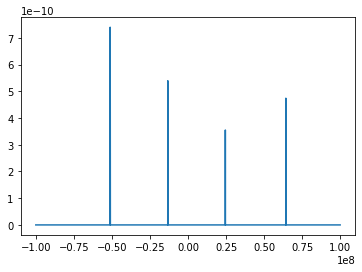

press enter


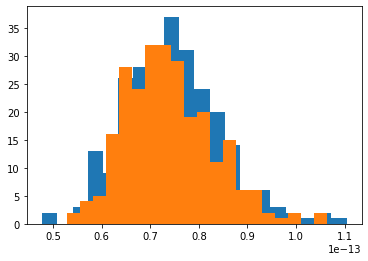

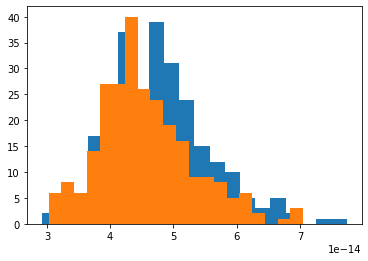

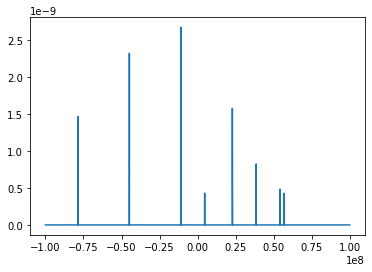

press enter


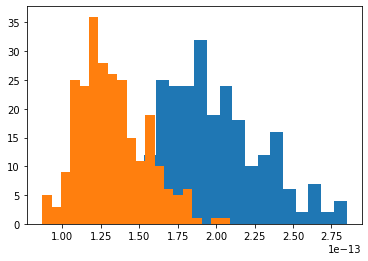

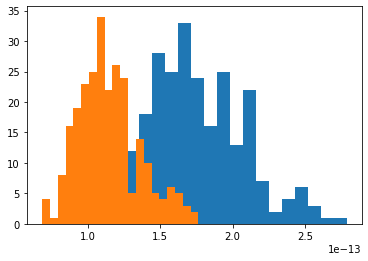

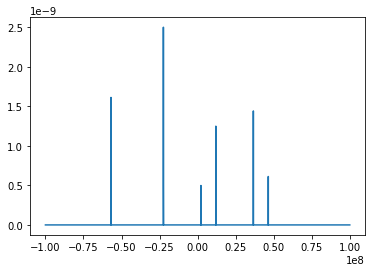

KeyboardInterrupt: Interrupted by user

In [8]:
eggPaths=[]
badEgg=[]
relativeMean=[]
if getEggFilePaths(simPath,eggPaths): # put all the found egg files into a list
    #print('test')
    for eggPath in eggPaths: # iterate over the simulation files

        simulationParams=[]
        getEggFileParams(eggPath,simulationParams)

        eggDataTime=MFParse.parse_egg(eggPath,Vrange=Vrange)
        eggSliceTime=MFParse.slice_egg(eggDataTime,nSlice,sliceSize)

        if MFParse.check_egg_slice(eggSliceTime): # check if the simulation is broken
            badEgg.append(eggPath)
            print(eggPath)
        else:
            tempDict={}

            eggSliceFFT,FFTFrequencies=MFTime.katydid_fft(eggSliceTime)
            trueSignalTime=eggSliceTime[0,:]
            trueSignalFreq=eggSliceFFT[0,:]/sliceSize
            
        
            freqInd,freqAmp=getSimpleFrequencyEstimate(trueSignalFreq)

            freq=FFTFrequencies[freqInd]
              
            simpleTemplate=getSimpleTemplate(freq,freqAmp,np.zeros(len(freq)),sliceSize,samplePeriod)
            
            plt.figure()
            plt.plot(FFTFrequencies,abs(np.fft.fftshift(np.fft.fft(simpleTemplate)))/8192)
            #plt.plot(freq,freqAmp,'.')
            plt.savefig('/Users/ziegler/repos/romulus/output/simpleTemplateSpectrum.png')
            plt.show()
            
            input('press enter')

            true=np.zeros(nTest)
            trueNoise=np.zeros(nTest)
            
            simple=np.zeros(nTest)
            simpleNoise=np.zeros(nTest)
            
            #fft=np.zeros(nTest)
            #fftNoise=np.zeros(nTest)
            
            for test in range(nTest):
                
                noisyData=addNoise(trueSignalTime,noiseVar)
                justNoise=addNoise(np.zeros(trueSignalTime.size,dtype=np.complex128),noiseVar)
                
                # do MF with omniscient filter on noisy data and just noise
                true[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,trueSignalTime,mode='full')))
                trueNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,trueSignalTime,mode='full')))
                
                #true[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(trueSignalTime))))
                #trueNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(trueSignalTime))))
                
                # do MF with simple filter on noisy data and just noise
                simple[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,simpleTemplate,mode='full')))
                simpleNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,simpleTemplate,mode='full')))
                
                # pick the max peak in a fft with noisy data and just noise as a baseline 
                #fft[test]=np.argmax(abs(np.fft.fft(noisyData)))
                #fftNoise[test]=np.argmax(abs(np.fft.fft(justNoise)))
            
            plt.figure()
            plt.hist(true,20)
            plt.hist(trueNoise,20)
            
            plt.figure()
            plt.hist(simple,20)
            plt.hist(simpleNoise,20)
            plt.show()
            #input('press enter')
            #trueHist=np.histogram(true,bins=20)
            #trueNoiseHist=np.histogram(trueNoise,bins=20)
            
            #simpleHist=np.histogram(simple,bins=20)
            #simpleNoiseHist=np.histogram(simpleNoise,bins=20)
            #print(trueHist)
            #print(np.mean(trueHist[1]*trueHist[0]),np.mean(trueNoiseHist[1]*trueNoiseHist[0]),
            #      np.mean(simpleHist[1]*simpleHist[0]),np.mean(simpleNoiseHist[1]*simpleNoiseHist[0]))
            relativeMeanOmni=(np.mean(true)-np.mean(trueNoise))/np.mean(trueNoise)
            relativeMeanSimple=(np.mean(simple)-np.mean(simpleNoise))/np.mean(simpleNoise)
            
            tempDict.update({'pa':simulationParams[0]})
            tempDict.update({'r':simulationParams[1]})
            tempDict.update({'sim':relativeMeanSimple})
            tempDict.update({'omni':relativeMeanOmni})
            
            relativeMean.append(tempDict)
            


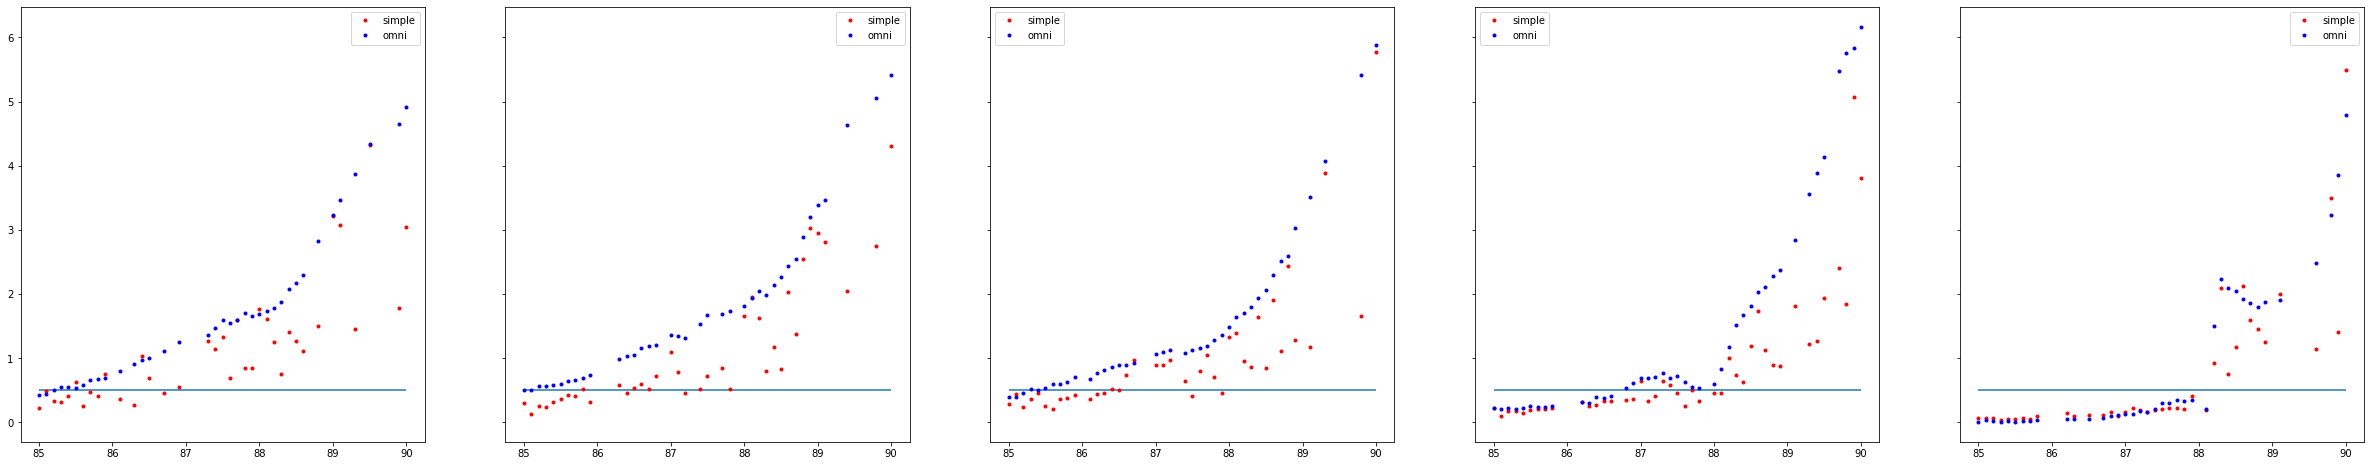

In [79]:
saveDataPath='/Users/ziegler/repos/romulus/output/2182021relativeMeanSimpleTemplateCorrectAmplitudeNoise1014.pkl'
with open(saveDataPath,'wb') as outfile:
    pkl.dump(relativeMean,outfile)
relativeMeanDF=pd.DataFrame(relativeMean)
#print(relativeMeanDF)

rads=np.arange(0.0,0.05,0.01)

fig,axs=plt.subplots(1,rads.size,sharey=True,figsize=(42,8))
for i,rad in enumerate(rads):
    tempDF=relativeMeanDF[relativeMeanDF["r"]==rad].sort_values('pa')
    
    axs[i].plot(tempDF['pa'],tempDF['sim'],'r.',label='simple')
    axs[i].plot(tempDF['pa'],tempDF['omni'],'b.',label='omni')
    axs[i].hlines(0.5,85,90)
    axs[i].legend(loc=0)

# Let's try the above convolution calculation but instead multiply in the Frequency domain

In [123]:
eggPaths=[]
badEgg=[]
relativeMeanConvThm=[]
if getEggFilePaths(simPath,eggPaths): # put all the found egg files into a list
    #print('test')
    for eggPath in eggPaths: # iterate over the simulation files

        simulationParams=[]
        getEggFileParams(eggPath,simulationParams)

        eggDataTime=MFParse.parse_egg(eggPath,Vrange=Vrange)
        eggSliceTime=MFParse.slice_egg(eggDataTime,nSlice,sliceSize)

        if MFParse.check_egg_slice(eggSliceTime): # check if the simulation is broken
            badEgg.append(eggPath)
            print(eggPath)
        else:
            tempDict={}

            eggSliceFFT,FFTFrequencies=MFTime.katydid_fft(eggSliceTime)
            trueSignalTime=eggSliceTime[0,:]
            trueSignalFreq=eggSliceFFT[0,:]/sliceSize

            freqInd,freqAmp=getSimpleFrequencyEstimate(trueSignalFreq)

            freq=FFTFrequencies[freqInd]

            simpleTemplate=getSimpleTemplate(freq,freqAmp,np.zeros(len(freq)),sliceSize,samplePeriod)

            true=np.zeros(nTest)
            trueNoise=np.zeros(nTest)
            
            simple=np.zeros(nTest)
            simpleNoise=np.zeros(nTest)
            
            #fft=np.zeros(nTest)
            #fftNoise=np.zeros(nTest)
            
            for test in range(nTest):
                
                noisyData=addNoise(trueSignalTime,noiseVar)
                justNoise=addNoise(np.zeros(trueSignalTime.size,dtype=np.complex128),noiseVar)
                
                # do MF with omniscient filter on noisy data and just noise
                true[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(trueSignalTime))))
                trueNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(trueSignalTime))))
                
                #true[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(trueSignalTime))))
                #trueNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(trueSignalTime))))
                
                # do MF with simple filter on noisy data and just noise
                simple[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(simpleTemplate))))
                simpleNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(simpleTemplate))))
                
                # pick the max peak in a fft with noisy data and just noise as a baseline 
                #fft[test]=np.argmax(abs(np.fft.fft(noisyData)))
                #fftNoise[test]=np.argmax(abs(np.fft.fft(justNoise)))
            
            #plt.figure()
            #plt.hist(true,20)
            #plt.hist(trueNoise,20)
            
            #plt.figure()
            #plt.hist(simple,20)
            #plt.hist(simpleNoise,20)
            #plt.show()
            #input('press enter')
            #trueHist=np.histogram(true,bins=20)
            #trueNoiseHist=np.histogram(trueNoise,bins=20)
            
            #simpleHist=np.histogram(simple,bins=20)
            #simpleNoiseHist=np.histogram(simpleNoise,bins=20)
            #print(trueHist)
            #print(np.mean(trueHist[1]*trueHist[0]),np.mean(trueNoiseHist[1]*trueNoiseHist[0]),
            #      np.mean(simpleHist[1]*simpleHist[0]),np.mean(simpleNoiseHist[1]*simpleNoiseHist[0]))
            relativeMeanOmni=(np.mean(true)-np.mean(trueNoise))/np.mean(trueNoise)
            relativeMeanSimple=(np.mean(simple)-np.mean(simpleNoise))/np.mean(simpleNoise)
            
            tempDict.update({'pa':simulationParams[0]})
            tempDict.update({'r':simulationParams[1]})
            tempDict.update({'sim':relativeMeanSimple})
            tempDict.update({'omni':relativeMeanOmni})
            
            relativeMeanConvThm.append(tempDict)

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle86.10_Pos0.043.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle89.30_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle86.20_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.028.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.025.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.020.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.030.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle86.20_Pos0.015.egg

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.020.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed604_Angle89.20_Pos0.022.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed604_Angle86.50_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle86.80_Pos0.035.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle86.80_Pos0.025.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle89.80_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.00_Pos0.022.egg

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed603_Angle86.40_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.00_Pos0.015.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.013.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle86.60_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle89.80_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.90_Pos0.030.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle86.70_Pos0.028.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle88.60_Pos0.048.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.90_Pos0.010.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle88.50_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.010.egg

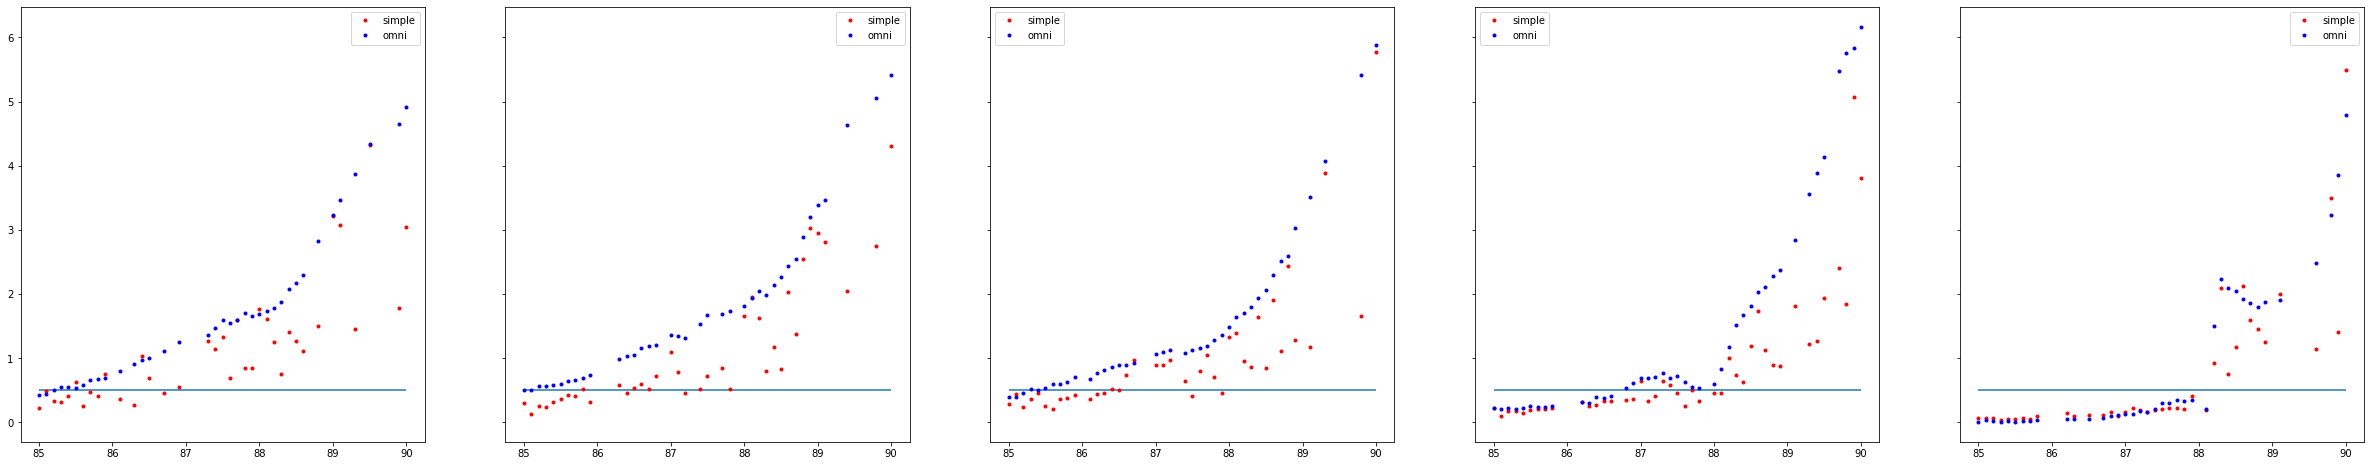

In [124]:
saveDataPath='/Users/ziegler/repos/romulus/output/2192021relativeMeanSimpleTemplateCorrectAmplitudeConvThrmNoise1014.pkl'
with open(saveDataPath,'wb') as outfile:
    pkl.dump(relativeMean,outfile)
relativeMeanDF=pd.DataFrame(relativeMean)
#print(relativeMeanDF)

rads=np.arange(0.0,0.05,0.01)

fig,axs=plt.subplots(1,rads.size,sharey=True,figsize=(42,8))
for i,rad in enumerate(rads):
    tempDF=relativeMeanDF[relativeMeanDF["r"]==rad].sort_values('pa')
    
    axs[i].plot(tempDF['pa'],tempDF['sim'],'r.',label='simple')
    axs[i].plot(tempDF['pa'],tempDF['omni'],'b.',label='omni')
    axs[i].hlines(0.5,85,90)
    axs[i].legend(loc=0)

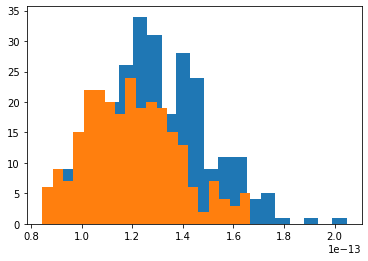

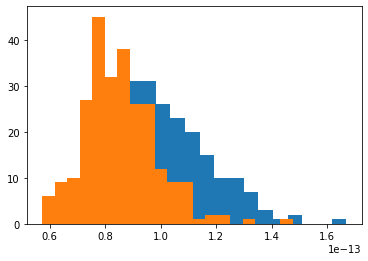

0.09405940276175172 0.15696494256372837
press enter



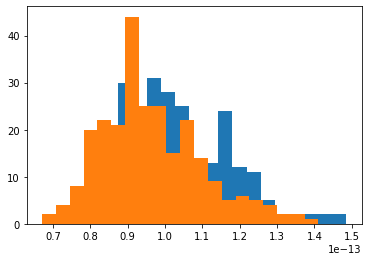

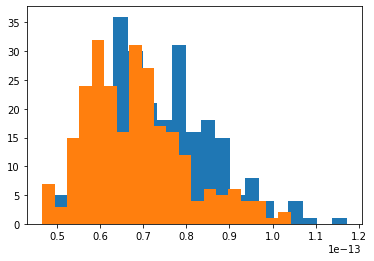

0.06350529024563298 0.08207021703914194
press enter

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle86.10_Pos0.043.egg


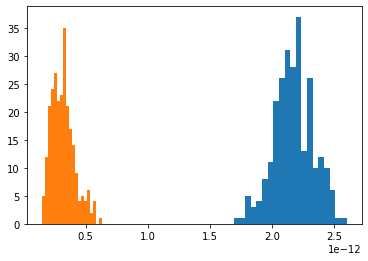

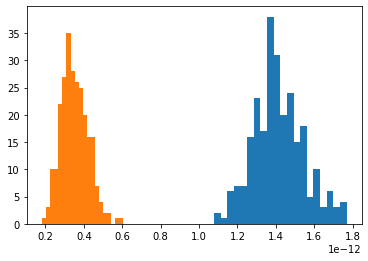

5.85037728496082 3.000223780224135
press enter



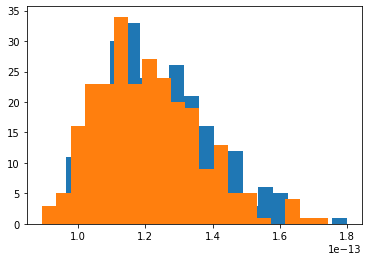

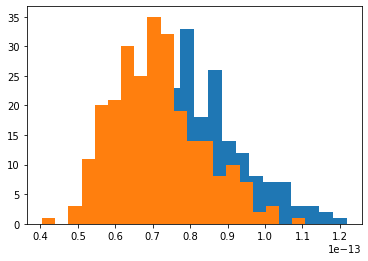

0.027993132526084413 0.11008250998527801
press enter



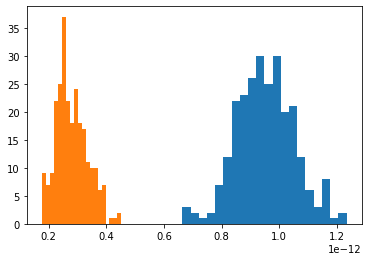

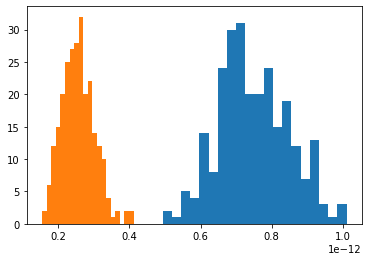

2.4010660276992173 1.9228608182532714
press enter



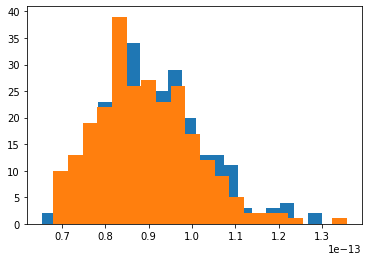

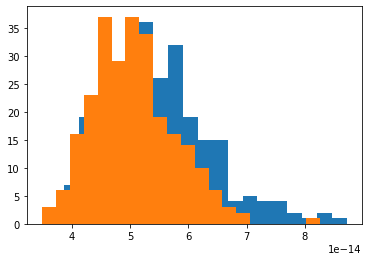

0.025334301630917724 0.08960807590462941
press enter

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle89.30_Pos0.037.egg


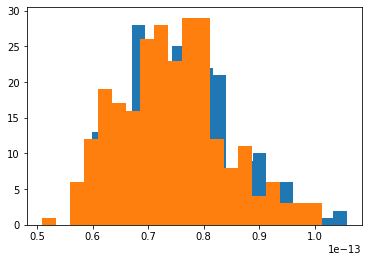

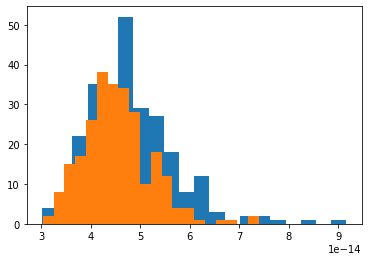

0.021152914803251155 0.06653423358432925
press enter



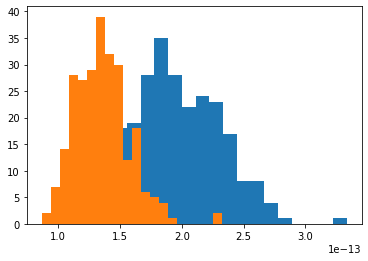

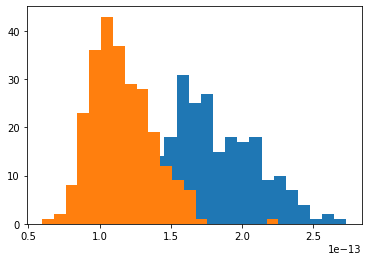

0.4366409263218098 0.5048165504321132
press enter



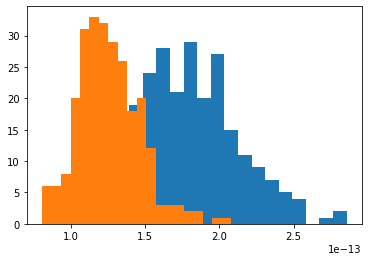

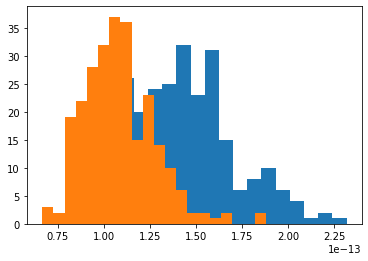

0.41404034954574287 0.31809102259950867
press enter



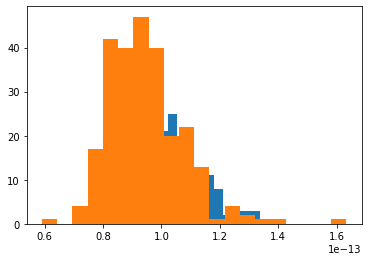

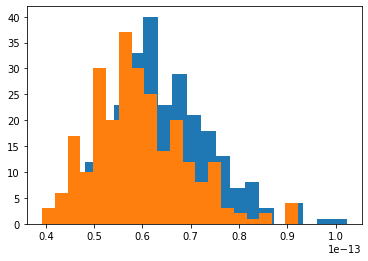

0.04506814215112694 0.08826340011992179
press enter



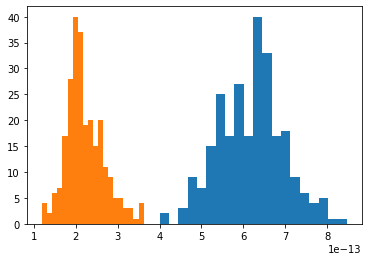

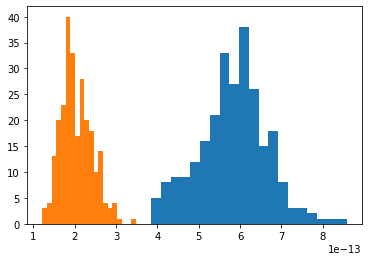

1.774845690292304 1.8513214414410393
press enter



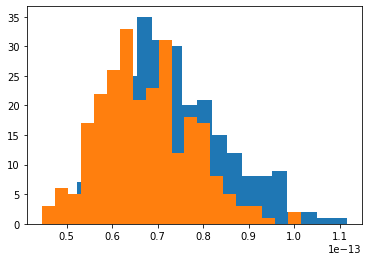

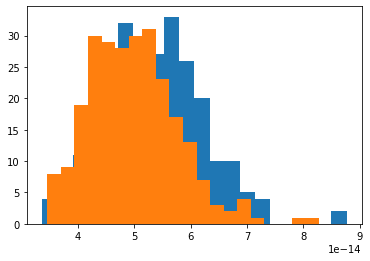

0.0893592913960439 0.08007069114632862
press enter



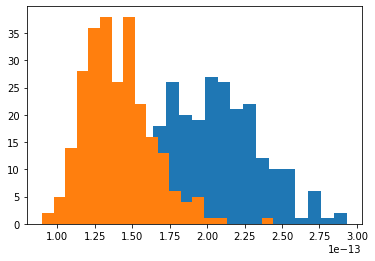

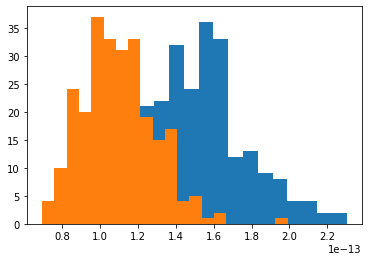

0.4281115695759073 0.3662331084460666


KeyboardInterrupt: Interrupted by user

In [83]:
eggPaths=[]
badEgg=[]
#relativeMean=[]
if getEggFilePaths(simPath,eggPaths): # put all the found egg files into a list
    #print('test')
    for eggPath in eggPaths: # iterate over the simulation files

        simulationParams=[]
        getEggFileParams(eggPath,simulationParams)

        eggDataTime=MFParse.parse_egg(eggPath,Vrange=Vrange)
        eggSliceTime=MFParse.slice_egg(eggDataTime,nSlice,sliceSize)

        if MFParse.check_egg_slice(eggSliceTime): # check if the simulation is broken
            badEgg.append(eggPath)
            print(eggPath)
        else:
            tempDict={}

            eggSliceFFT,FFTFrequencies=MFTime.katydid_fft(eggSliceTime)
            trueSignalTime=eggSliceTime[0,:]
            trueSignalFreq=eggSliceFFT[0,:]/sliceSize

            freqInd,freqAmp=getSimpleFrequencyEstimate(trueSignalFreq)

            freq=FFTFrequencies[freqInd]

            simpleTemplate=getSimpleTemplate(freq,freqAmp,np.zeros(len(freq)),sliceSize,samplePeriod)

            true=np.zeros(nTest)
            trueNoise=np.zeros(nTest)
            
            simple=np.zeros(nTest)
            simpleNoise=np.zeros(nTest)
            
            #fft=np.zeros(nTest)
            #fftNoise=np.zeros(nTest)
            
            for test in range(nTest):
                
                noisyData=addNoise(trueSignalTime,noiseVar)
                justNoise=addNoise(np.zeros(trueSignalTime.size,dtype=np.complex128),noiseVar)
                
                # do MF with omniscient filter on noisy data and just noise
                true[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,trueSignalTime,mode='full')))
                trueNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,trueSignalTime,mode='full')))
                
                #true[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(trueSignalTime))))
                #trueNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(trueSignalTime))))
                
                # do MF with simple filter on noisy data and just noise
                simple[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,simpleTemplate,mode='full')))
                simpleNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,simpleTemplate,mode='full')))
                
                # pick the max peak in a fft with noisy data and just noise as a baseline 
                #fft[test]=np.argmax(abs(np.fft.fft(noisyData)))
                #fftNoise[test]=np.argmax(abs(np.fft.fft(justNoise)))
            
            plt.figure()
            plt.hist(true,20)
            plt.hist(trueNoise,20)
            
            plt.figure()
            plt.hist(simple,20)
            plt.hist(simpleNoise,20)
            plt.show()
            relativeMeanOmni=(np.mean(true)-np.mean(trueNoise))/np.mean(trueNoise)
            relativeMeanSimple=(np.mean(simple)-np.mean(simpleNoise))/np.mean(simpleNoise)
            print(relativeMeanOmni,relativeMeanSimple)
            input('press enter')
            #trueHist=np.histogram(true,bins=20)
            #trueNoiseHist=np.histogram(trueNoise,bins=20)
            
            #simpleHist=np.histogram(simple,bins=20)
            #simpleNoiseHist=np.histogram(simpleNoise,bins=20)
            #print(trueHist)
            #print(np.mean(trueHist[1]*trueHist[0]),np.mean(trueNoiseHist[1]*trueNoiseHist[0]),
            #      np.mean(simpleHist[1]*simpleHist[0]),np.mean(simpleNoiseHist[1]*simpleNoiseHist[0]))
            
            
            print()
            tempDict.update({'pa':simulationParams[0]})
            tempDict.update({'r':simulationParams[1]})
            tempDict.update({'sim':relativeMeanSimple})
            tempDict.update({'omni':relativeMeanOmni})
            
            #relativeMean.append(tempDict)

# compare simple template with uniform amplitude

In [80]:
eggPaths=[]
badEgg=[]
relativeMeanUniAmp=[]
if getEggFilePaths(simPath,eggPaths): # put all the found egg files into a list
    #print('test')
    for eggPath in eggPaths: # iterate over the simulation files

        simulationParams=[]
        getEggFileParams(eggPath,simulationParams)

        eggDataTime=MFParse.parse_egg(eggPath,Vrange=Vrange)
        eggSliceTime=MFParse.slice_egg(eggDataTime,nSlice,sliceSize)

        if MFParse.check_egg_slice(eggSliceTime): # check if the simulation is broken
            badEgg.append(eggPath)
            print(eggPath)
        else:
            tempDict={}

            eggSliceFFT,FFTFrequencies=MFTime.katydid_fft(eggSliceTime)
            trueSignalTime=eggSliceTime[0,:]
            trueSignalFreq=eggSliceFFT[0,:]/sliceSize

            freqInd,freqAmp=getSimpleFrequencyEstimate(trueSignalFreq)
            
            freqAmp=np.mean(freqAmp)*np.ones(freqAmp.size)

            freq=FFTFrequencies[freqInd]

            simpleTemplate=getSimpleTemplate(freq,freqAmp,np.zeros(len(freq)),sliceSize,samplePeriod)

            true=np.zeros(nTest)
            trueNoise=np.zeros(nTest)
            
            simple=np.zeros(nTest)
            simpleNoise=np.zeros(nTest)
            
            #fft=np.zeros(nTest)
            #fftNoise=np.zeros(nTest)
            
            for test in range(nTest):
                
                noisyData=addNoise(trueSignalTime,noiseVar)
                justNoise=addNoise(np.zeros(trueSignalTime.size,dtype=np.complex128),noiseVar)
                
                # do MF with omniscient filter on noisy data and just noise
                true[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,trueSignalTime,mode='full')))
                trueNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,trueSignalTime,mode='full')))
                
                #true[test]=np.max(abs(np.fft.ifft(np.fft.fft(noisyData)*np.fft.fft(trueSignalTime))))
                #trueNoise[test]=np.max(abs(np.fft.ifft(np.fft.fft(justNoise)*np.fft.fft(trueSignalTime))))
                
                # do MF with simple filter on noisy data and just noise
                simple[test]=np.max(abs(scipy.signal.fftconvolve(noisyData,simpleTemplate,mode='full')))
                simpleNoise[test]=np.max(abs(scipy.signal.fftconvolve(justNoise,simpleTemplate,mode='full')))
                
                # pick the max peak in a fft with noisy data and just noise as a baseline 
                #fft[test]=np.argmax(abs(np.fft.fft(noisyData)))
                #fftNoise[test]=np.argmax(abs(np.fft.fft(justNoise)))
            
          
            #trueHist=np.histogram(true,bins=20)
            #trueNoiseHist=np.histogram(trueNoise,bins=20)
            
            #simpleHist=np.histogram(simple,bins=20)
            #simpleNoiseHist=np.histogram(simpleNoise,bins=20)
            #print(trueHist)
            #print(np.mean(trueHist[1]*trueHist[0]),np.mean(trueNoiseHist[1]*trueNoiseHist[0]),
            #      np.mean(simpleHist[1]*simpleHist[0]),np.mean(simpleNoiseHist[1]*simpleNoiseHist[0]))
            relativeMeanOmni=(np.mean(true)-np.mean(trueNoise))/np.mean(trueNoise)
            relativeMeanSimple=(np.mean(simple)-np.mean(simpleNoise))/np.mean(simpleNoise)
            
            tempDict.update({'pa':simulationParams[0]})
            tempDict.update({'r':simulationParams[1]})
            tempDict.update({'sim':relativeMeanSimple})
            tempDict.update({'omni':relativeMeanOmni})
            
            relativeMeanUniAmp.append(tempDict)
            



/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle86.10_Pos0.043.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle89.30_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle86.20_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.00_Pos0.028.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.025.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.020.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.030.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle86.20_Pos0.015.egg

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.020.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed604_Angle89.20_Pos0.022.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed604_Angle86.50_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle86.80_Pos0.035.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle86.80_Pos0.025.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle89.80_Pos0.000.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle89.50_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.018.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.00_Pos0.022.egg

/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed603_Angle86.40_Pos0.050.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.00_Pos0.015.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle89.40_Pos0.013.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed605_Angle86.60_Pos0.040.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed601_Angle89.80_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed600_Angle87.90_Pos0.030.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle86.70_Pos0.028.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed607_Angle88.60_Pos0.048.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed602_Angle89.90_Pos0.010.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed606_Angle88.50_Pos0.037.egg
/Users/ziegler/p8/egg_files/eggsTemplates1252021/locust_mc_Seed608_Angle89.60_Pos0.010.egg

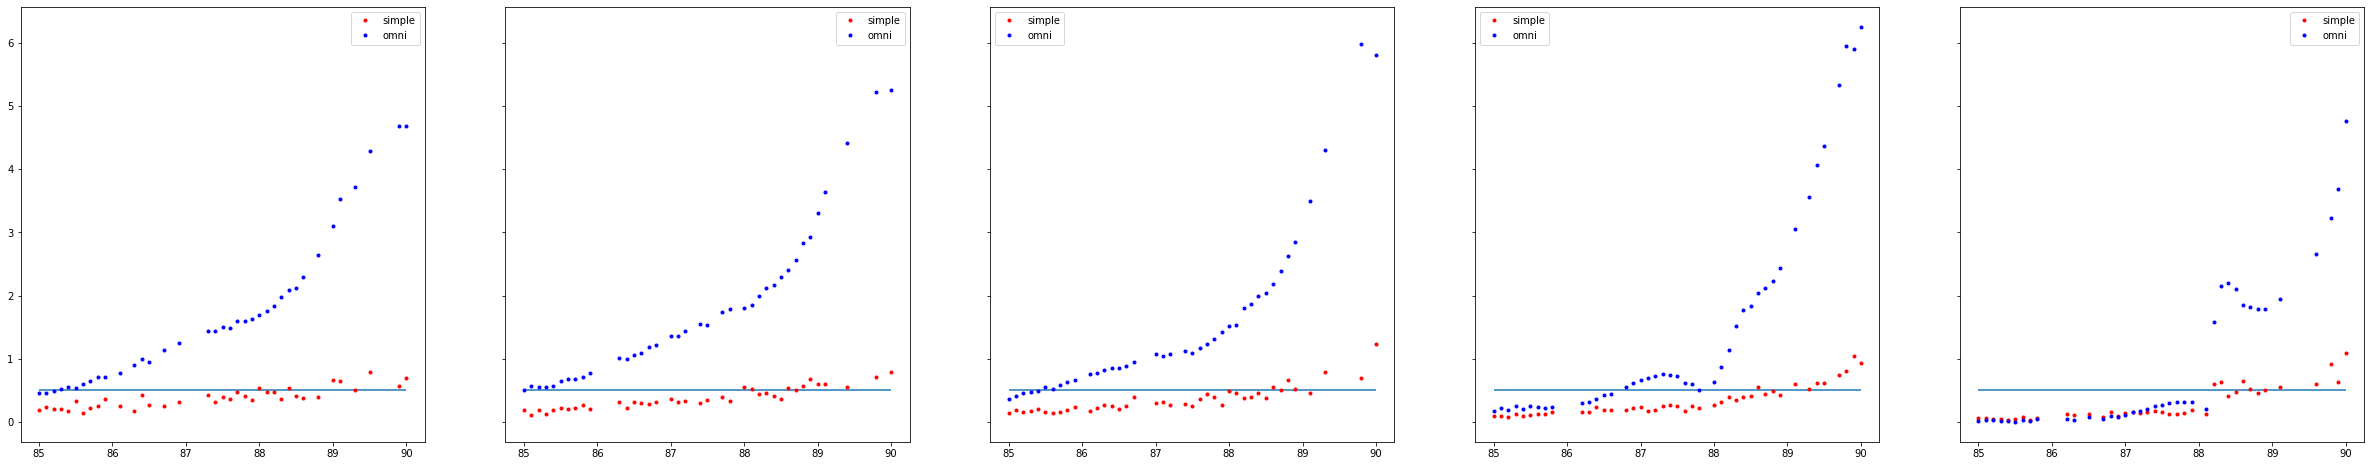

In [81]:
saveDataPath='/Users/ziegler/repos/romulus/output/2182021relativeMeanSimpleTemplateUniformAmplitudeNoise1014.pkl'
with open(saveDataPath,'wb') as outfile:
    pkl.dump(relativeMean,outfile)
relativeMeanDF=pd.DataFrame(relativeMean)

relativeMeanUniAmpDF=pd.DataFrame(relativeMeanUniAmp)
#print(relativeMeanDF)

rads=np.arange(0.0,0.05,0.01)

fig,axs=plt.subplots(1,rads.size,sharey=True,figsize=(42,8))
for i,rad in enumerate(rads):
    tempDF=relativeMeanUniAmpDF[relativeMeanUniAmpDF["r"]==rad].sort_values('pa')
    
    axs[i].plot(tempDF['pa'],tempDF['sim'],'r.',label='simple')
    axs[i].plot(tempDF['pa'],tempDF['omni'],'b.',label='omni')
    axs[i].hlines(0.5,85,90)
    axs[i].legend(loc=0)

# How does a coherent signal and noise add (Answer: noise power scales as a factor of N and signal power scales as a factor of N^2 so SNR should scale as N)

In [120]:
testVariance=1e-14
numberAdd=10
justNoise=np.zeros(sliceSize,dtype=np.complex128)
for i in range(numberAdd):
    justNoise=addNoise(justNoise,testVariance)

print(np.mean(abs(justNoise)**2))

testTime=np.arange(0,sliceSize,1)*samplePeriod
testFreq=10e6
testAmp=1

justSignal=np.zeros(sliceSize,dtype=np.complex128)
for i in range(numberAdd):
    justSignal+=testAmp*np.exp(-1j*2*np.pi*testTime*testFreq)
    
print(np.mean(abs(justSignal)**2))



9.899497410401391e-14
100.0
